**GMDL, Final Project**

Yuval Tuchman - 209039999

Ohad Barzilay - 318321908

[Colab Link](https://colab.research.google.com/drive/1UAZ2Qsf99SHe_qAb8zBGh5xaoOWf_o6y?usp=sharing)

In [ ]:

import matplotlib.pyplot as plt
from torch.optim import Adam
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
import project_utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Models**

**Baseine Model**

In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self, hidden_sizes_conv=[1,16,32], hidden_sizes_linear=120, output_size=10, kernel_size=5):
        super().__init__()
        self.conv1 = nn.Conv2d(hidden_sizes_conv[0], hidden_sizes_conv[1], kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hidden_sizes_conv[1], hidden_sizes_conv[2], kernel_size)
        self.fc1 = nn.Linear(hidden_sizes_conv[2] * 4 * 4, hidden_sizes_linear)
        self.fc2 = nn.Linear(hidden_sizes_linear, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output

**OSR Model**

In [ ]:
class CNN(nn.Module):
    def __init__(self, hidden_sizes_conv=[1,16,32], hidden_sizes_linear=120, output_size=10, kernel_size=5, num_of_passes=10, threshold=0.5):
        super().__init__()
        self.num_of_passes = num_of_passes
        self.threshold = threshold
        self.conv1 = nn.Conv2d(hidden_sizes_conv[0], hidden_sizes_conv[1], kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hidden_sizes_conv[1], hidden_sizes_conv[2], kernel_size)
        self.dropout = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(hidden_sizes_conv[2] * 4 * 4, hidden_sizes_linear)
        self.fc2 = nn.Linear(hidden_sizes_linear, output_size)

    def set_threshold(self, threshold):
        self.threshold = threshold

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output
    def predict(self, inputs):
        output = [nn.Softmax(dim=1)(self.forward(inputs)) for _ in range(self.num_of_passes)]
        output = torch.stack(output)
        output = torch.mean(output, dim=0)
        max_values, preds = torch.max(output, 1)
        preds[max_values < self.threshold] = 10
        return output, preds




We chose to use CNN for our baseline model with 2 convolution layers with sizes 1, 16, 32 with a kernel size of 5 and a 2x2 max pooling layer between each convolution layer and two fully connected linear layers.
For our OSR model, we extend out baseline model using a MC Dropout layer to leverage uncertainty.


**Data & preprocessing**

In [ ]:
def get_test_data():
  batch_size = 512
  mnist_transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize((28,28))])
  mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_transform)
  t_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
  return t_loader

def get_ood_test_loader():
    batch_size = 1024
    mnist_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize((28,28))])
    cifar_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,)),
                                          transforms.Grayscale(num_output_channels=1),
                                           transforms.Resize((28,28)),
                                          transforms.Resize((28,28))])
    mnist = MNIST(root='./data', train=False, download=True, transform=mnist_transform)
    ood = CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)
    # take 20% from ood (CIFAR) = 2000 samples
    ood = torch.utils.data.Subset(ood, np.random.choice(len(ood), int(len(ood) * 0.2), replace=False))
    ood_test = project_utils.CombinedDataset(mnist, ood)
    ood_test_loader = DataLoader(ood_test, batch_size=batch_size, shuffle=True)
    return ood_test_loader

def get_train_val_data():
  batch_size = 128
  mnist_transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize((28,28))])
  mnist = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
  train_size = int(0.8 * len(mnist))
  mnist_train, mnist_val = random_split(mnist, [train_size, len(mnist) - train_size])

  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
  validation_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=True)
  return train_loader, validation_loader
def plot_stats(train_acc, val_acc, train_losses, val_losses):
    # subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    axs[0].plot(train_losses, label='train')
    axs[0].plot(val_losses, label='validation')
    axs[0].set_title('Loss')
    axs[0].legend()
    axs[1].plot(train_acc, label='train')
    axs[1].plot(val_acc, label='validation')
    axs[1].set_title('Accuracy')
    axs[1].legend()
    plt.tight_layout()
    plt.show()



**Training model**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, num_of_passes=20, threshold=0.5, OOD=True):
    train_loader, val_loader = get_train_val_data()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_acc_arr = []
    val_acc_arr = []


    for epoch in range(num_epochs):
      model.train()

      curr_loss = 0.0
      curr_val_loss = 0.0
      train_acc = 0.0
      val_acc = 0.0

      for data in train_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
          output = model(inputs)
          _, preds = torch.max(output, 1)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()
          curr_loss += loss.item() * inputs.size(0)
          train_acc += torch.sum(preds == labels.data).double()
      scheduler.step()

      for data in val_loader:
        model.train() # model.eval() will turn off the dropout
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        if OOD:
          output, preds = model.predict(inputs)
        else:
          max_values, preds = torch.max(output, 1)
        loss = criterion(output, labels)


        curr_val_loss += loss.item() * inputs.size(0)
        val_acc += torch.sum(preds == labels.data).double()


      val_loss_per_epoch = curr_val_loss / len(val_loader.dataset)
      val_losses.append(val_loss_per_epoch)
      train_loss_per_epoch = curr_loss / len(train_loader.dataset)
      train_losses.append(train_loss_per_epoch)


      val_acc_per_epoch = val_acc / len(val_loader.dataset)
      val_acc_arr.append(val_acc_per_epoch)
      train_acc_per_epoch = train_acc / len(train_loader.dataset)
      train_acc_arr.append(train_acc_per_epoch)

      print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}, train_acc:{:.4f}%, val_acc:{:.4f}%'
              .format(epoch + 1, num_epochs, train_loss_per_epoch, val_loss_per_epoch,
                      train_acc_per_epoch * 100, val_acc_per_epoch * 100))

      if val_acc_per_epoch > best_acc:
        # take the model with best acc on the validation set
        best_acc = val_acc_per_epoch
        best_model = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model)
    if OOD:
      torch.save(model.state_dict(), './OSR_CNN.pth')
    else:
      torch.save(model.state_dict(), './Baseline_CNN.pth')
    return train_acc_arr, val_acc_arr, train_losses, val_losses

In [ ]:
criterion = nn.CrossEntropyLoss()

Baseline_model = BaselineCNN().to(device)
optimizer = Adam(Baseline_model.parameters(), lr=0.01)
schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
train_acc_base, val_acc_base, train_losses_base, val_losses_base = train_model(Baseline_model, criterion, optimizer, schedule, threshold=0.6, OOD=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 87214941.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37701741.00it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25250155.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15835851.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch [1/15], train_loss:0.1954, val_loss:0.0697, train_acc:93.9208%, val_acc:97.5500%
epoch [2/15], train_loss:0.0795, val_loss:0.0859, train_acc:97.5750%, val_acc:97.4417%
epoch [3/15], train_loss:0.0755, val_loss:0.0888, train_acc:97.7375%, val_acc:97.4750%
epoch [4/15], train_loss:0.0694, val_loss:0.0899, train_acc:97.9667%, val_acc:97.4417%
epoch [5/15], train_loss:0.0686, val_loss:0.0648, train_acc:97.9750%, val_acc:98.2583%
epoch [6/15], train_loss:0.0647, val_loss:0.0884, train_acc:98.1750%, val_acc:97.8583%
epoch [7/15], train_loss:0.0736, val_loss:0.0650, train_acc:98.0333%, val_acc:98.1583%
epoch [8/15], train_loss:0.0661, val_loss:0.0960, train_acc:98.2750%, val_acc:97.7417%
epoch [9/15], train_loss:0.0639, val_loss:0.0746, train_acc:98.2708%, val_acc:98.1917%
epoch [10/15], train_loss:0.0668, val_loss:0.1083, train_acc:98.2021%, val_acc:97.6000%
epoch [11/15], train_loss:0.0350, val_loss:0.0596, train_acc:99.0271%, val_acc:98.6000%
epoch [12/15], train_loss:0.0193, val_los

In [ ]:
model = CNN().to(device)
optimizer = Adam(model.parameters(), lr=0.01)
schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
train_acc, val_acc, train_losses, val_losses = train_model(model, criterion, optimizer, schedule, threshold=0.6, OOD=True)

epoch [1/15], train_loss:0.3127, val_loss:1.5299, train_acc:90.3292%, val_acc:96.0750%
epoch [2/15], train_loss:0.1706, val_loss:1.5133, train_acc:94.8583%, val_acc:96.8083%
epoch [3/15], train_loss:0.1499, val_loss:1.5174, train_acc:95.6187%, val_acc:96.9667%
epoch [4/15], train_loss:0.1540, val_loss:1.5141, train_acc:95.5417%, val_acc:97.1167%
epoch [5/15], train_loss:0.1498, val_loss:1.5103, train_acc:95.5917%, val_acc:97.2333%
epoch [6/15], train_loss:0.1413, val_loss:1.5074, train_acc:96.0250%, val_acc:97.1250%
epoch [7/15], train_loss:0.1431, val_loss:1.5111, train_acc:96.0375%, val_acc:97.2833%
epoch [8/15], train_loss:0.1379, val_loss:1.5034, train_acc:96.1354%, val_acc:97.5083%
epoch [9/15], train_loss:0.1305, val_loss:1.5081, train_acc:96.3896%, val_acc:97.2333%
epoch [10/15], train_loss:0.1438, val_loss:1.5066, train_acc:96.1375%, val_acc:97.1000%
epoch [11/15], train_loss:0.0931, val_loss:1.4955, train_acc:97.3625%, val_acc:97.9333%
epoch [12/15], train_loss:0.0781, val_los

**Loss & accuracy graphs for training models**

**Baseline Model Graph**

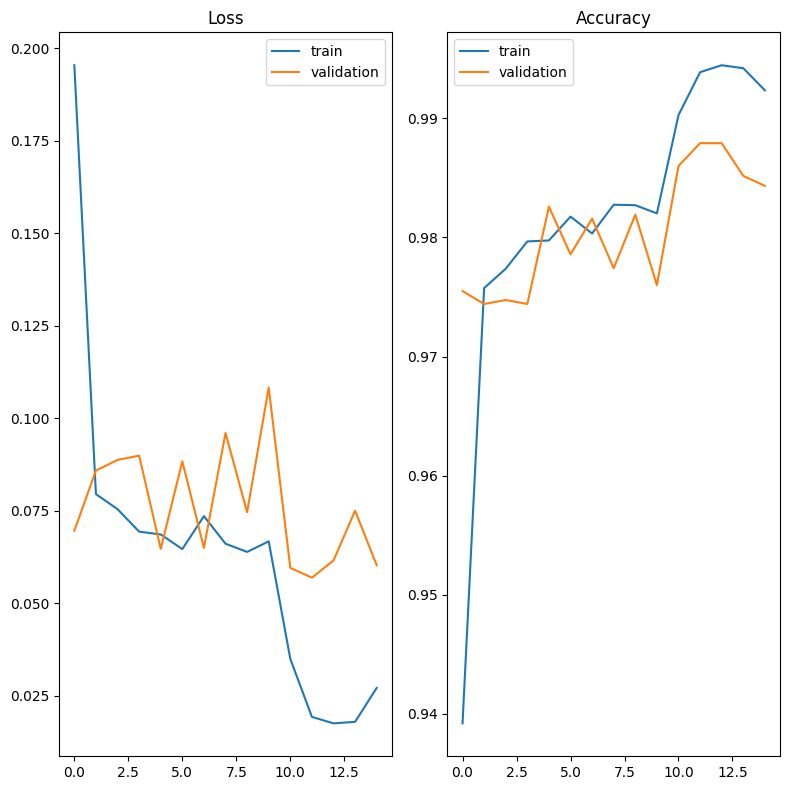

In [ ]:
if type(train_acc[0]) != float:
  train_acc_base = [acc.item() for acc in train_acc_base]
  val_acc_base = [acc.item() for acc in val_acc_base]
plot_stats(train_acc_base, val_acc_base, train_losses_base, val_losses_base)

**OSR Graph**

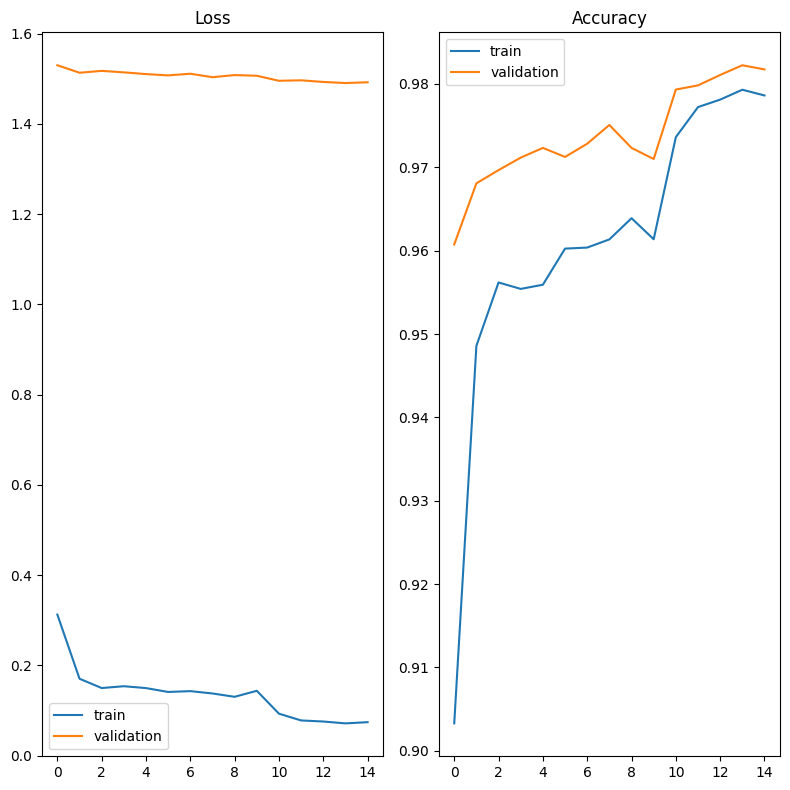

In [ ]:
if type(train_acc[0]) != float:
  train_acc = [acc.item() for acc in train_acc]
  val_acc = [acc.item() for acc in val_acc]
plot_stats(train_acc, val_acc, train_losses, val_losses)

**Evaluation**

In [ ]:
def test_model(test_loader, model, num_of_passes=10, threshold=0.5, OOD=True):
    test_acc = 0
    all_predictions = []
    all_labels = []
    for data in test_loader:
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = []
        if OOD:
          model.set_threshold(threshold)
          output, preds = model.predict(inputs)
        else:
          output = model(inputs)
          max_values, preds = torch.max(output, 1)

        test_acc += (preds == labels).float().mean().item()
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    test_acc /= len(test_loader)
    return all_predictions, all_labels, test_acc * 100


def plot_conf_matrix(labels, predictions, num_classes, title):
    cnf_matrix = confusion_matrix(labels, predictions, labels=range(num_classes))
    plt.title(title)
    sns.heatmap(cnf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))

In [ ]:
Baseline_model = BaselineCNN().to(device)
Baseline_model.load_state_dict(torch.load('./Baseline_CNN.pth'))
model = CNN().to(device)
model.load_state_dict(torch.load('./OSR_CNN.pth'))

<All keys matched successfully>

**Threshold hyperparameter optimization** -
We used optuna to choose the best threshold of probabilties in order to classify unknown images (The level of the model's uncertainty).
Optuna enables efficient hyperparameter optimization by adopting state-of-the-art algorithms for sampling hyperparameters and pruning efficiently unpromising trials.

In [ ]:
!pip install optuna
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history

def objective_OOD(trial):
    threshold = trial.suggest_float('threshold', 0.1, 0.9)
    ood_test_loader = get_ood_test_loader()
    ood_predictions, ood_labels, ood_test_acc = test_model(ood_test_loader, model, 10, threshold)
    return ood_test_acc


sampler = TPESampler(seed=10)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_OOD, n_trials=20)
print('best threshold with ood: {}'.format(study.best_params))
print('best accuracy with ood: {}'.format(study.best_value))
plot_optimization_history(study)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.1 MB/s eta 0:00:00


[I 2023-07-31 14:35:09,356] A new study created in memory with name: no-name-6d69bf27-0fb5-4849-a05f-0074b38f9917


100%|██████████| 170498071/170498071 [00:06<00:00, 28132789.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[I 2023-07-31 14:35:24,557] Trial 0 finished with value: 97.49950468540192 and parameters: {'threshold': 0.7170565146133968}. Best is trial 0 with value: 97.49950468540192.


Files already downloaded and verified


[I 2023-07-31 14:35:30,100] Trial 1 finished with value: 82.39073852698007 and parameters: {'threshold': 0.11660155948752121}. Best is trial 0 with value: 97.49950468540192.


Files already downloaded and verified


[I 2023-07-31 14:35:35,961] Trial 2 finished with value: 98.30658435821533 and parameters: {'threshold': 0.6069185879410204}. Best is trial 2 with value: 98.30658435821533.


Files already downloaded and verified


[I 2023-07-31 14:35:41,360] Trial 3 finished with value: 97.69941717386246 and parameters: {'threshold': 0.6990431060308895}. Best is trial 2 with value: 98.30658435821533.


Files already downloaded and verified


[I 2023-07-31 14:35:47,632] Trial 4 finished with value: 98.80583385626474 and parameters: {'threshold': 0.49880560984207234}. Best is trial 4 with value: 98.80583385626474.


Files already downloaded and verified


[I 2023-07-31 14:35:53,005] Trial 5 finished with value: 98.7665593624115 and parameters: {'threshold': 0.27983731642467813}. Best is trial 4 with value: 98.80583385626474.


Files already downloaded and verified


[I 2023-07-31 14:35:59,185] Trial 6 finished with value: 96.86650832494101 and parameters: {'threshold': 0.2584502918076992}. Best is trial 4 with value: 98.80583385626474.


Files already downloaded and verified


[I 2023-07-31 14:36:04,570] Trial 7 finished with value: 97.55187133948007 and parameters: {'threshold': 0.708424569759167}. Best is trial 4 with value: 98.80583385626474.


Files already downloaded and verified


[I 2023-07-31 14:36:10,731] Trial 8 finished with value: 85.95023800929388 and parameters: {'threshold': 0.23528866925002836}. Best is trial 4 with value: 98.80583385626474.


Files already downloaded and verified


[I 2023-07-31 14:36:16,291] Trial 9 finished with value: 82.39038437604904 and parameters: {'threshold': 0.1706718513392082}. Best is trial 4 with value: 98.80583385626474.


Files already downloaded and verified


[I 2023-07-31 14:36:22,189] Trial 10 finished with value: 98.83201718330383 and parameters: {'threshold': 0.45531160757048217}. Best is trial 10 with value: 98.83201718330383.


Files already downloaded and verified


[I 2023-07-31 14:36:27,832] Trial 11 finished with value: 98.81432602802911 and parameters: {'threshold': 0.45915423712186404}. Best is trial 10 with value: 98.83201718330383.


Files already downloaded and verified


[I 2023-07-31 14:36:33,282] Trial 12 finished with value: 98.83201718330383 and parameters: {'threshold': 0.45040445977422017}. Best is trial 10 with value: 98.83201718330383.


Files already downloaded and verified


[I 2023-07-31 14:36:39,393] Trial 13 finished with value: 98.87730727593103 and parameters: {'threshold': 0.37919039207834604}. Best is trial 13 with value: 98.87730727593103.


Files already downloaded and verified


[I 2023-07-31 14:36:44,750] Trial 14 finished with value: 98.9717791477839 and parameters: {'threshold': 0.3791163086229386}. Best is trial 14 with value: 98.9717791477839.


Files already downloaded and verified


[I 2023-07-31 14:36:50,990] Trial 15 finished with value: 98.95125677188238 and parameters: {'threshold': 0.35073349039764845}. Best is trial 14 with value: 98.9717791477839.


Files already downloaded and verified


[I 2023-07-31 14:36:56,449] Trial 16 finished with value: 95.02554635206857 and parameters: {'threshold': 0.8787281521236581}. Best is trial 14 with value: 98.9717791477839.


Files already downloaded and verified


[I 2023-07-31 14:37:02,599] Trial 17 finished with value: 98.97000988324484 and parameters: {'threshold': 0.3497916102122423}. Best is trial 14 with value: 98.9717791477839.


Files already downloaded and verified


[I 2023-07-31 14:37:08,155] Trial 18 finished with value: 98.88721406459808 and parameters: {'threshold': 0.33854216512539415}. Best is trial 14 with value: 98.9717791477839.


Files already downloaded and verified


[I 2023-07-31 14:37:14,190] Trial 19 finished with value: 98.90844374895096 and parameters: {'threshold': 0.38952796499083636}. Best is trial 14 with value: 98.9717791477839.


best threshold with ood: {'threshold': 0.3791163086229386}
best accuracy with ood: 98.9717791477839


**OSR Rational** -

> We chose to levrage the uncertainty of the model in order to to flag unseen classes. We used an MC dropout layer during inference it makes multiple predictions for each input by trying different methods of ignoring some parts of the network. One good thing about this is that it tells us how certain or uncertain the model is about its predictions. By getting several predictions for a single input, we can see how confident the model is and make better decisions. This is especially useful when dealing with inputs that are very different from what the model has seen before.


**OSR Results**

**Confusion matrix** - provides a clearer picture of how well the model performs for each individual class, allowing us to identify which classes are well-predicted and which ones need improvement.


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



test accuracy without ood: 98.8413%


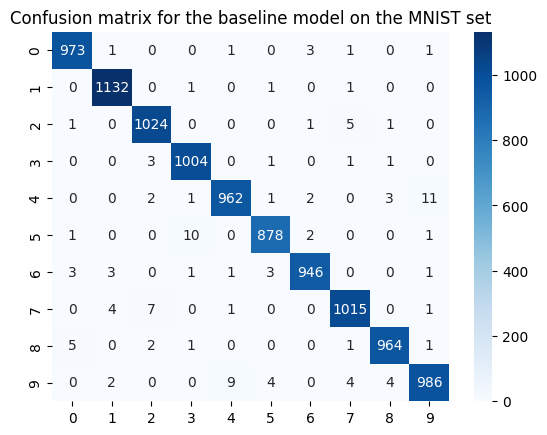

In [ ]:

test_loader = get_test_data()
predictions, labels, test_acc = test_model(test_loader, Baseline_model, OOD=False)
plot_conf_matrix(labels, predictions, 10, 'Confusion matrix for the baseline model on the MNIST set')
print('test accuracy without ood: {:.4f}%'.format(test_acc))

We can see that the confusion matrix of the Baseline model is almost diagonal, that means that out models achieves good accuracy and there is strong correlation between the predicted label and the Truth label.


Files already downloaded and verified
test accuracy with ood: 98.9084%


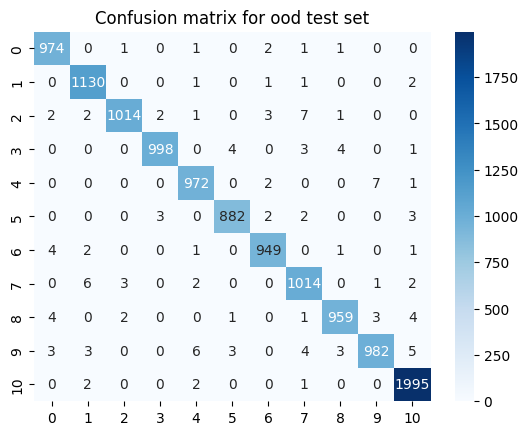

In [ ]:
ood_test_loader = get_ood_test_loader()
ood_predictions, ood_labels, ood_test_acc = test_model(ood_test_loader, model, threshold=0.3791) # best threshold from optuna study
plot_conf_matrix(ood_labels, ood_predictions, 11, 'Confusion matrix for ood test set')
print('test accuracy with ood: {:.4f}%'.format(ood_test_acc))

We can see that the confusion matrix of the OSR model is almost diagonal, that means that out models achieves good accuracy and there is strong correlation between the predicted label and the Truth label.

Binary accuracy score:  99.8 %
Balanced accuracy score:  99.78 %


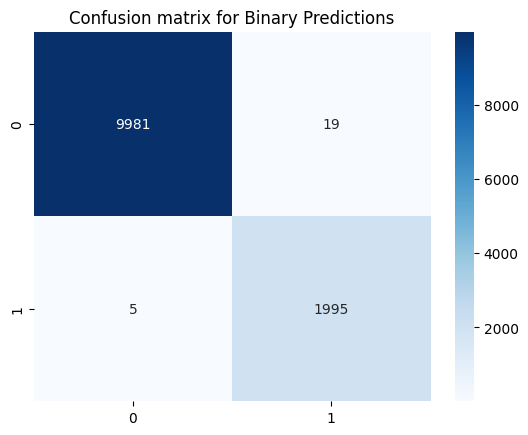

In [ ]:
binary_predictions = np.array(ood_predictions) == 10
binary_labels = np.array(ood_labels) == 10

print("Binary accuracy score: ", np.mean(binary_predictions == binary_labels) * 100, "%")
print("Balanced accuracy score: ", balanced_accuracy_score(binary_labels, binary_predictions) * 100, "%")
plot_conf_matrix(binary_labels, binary_predictions, 2, 'Confusion matrix for Binary Predictions')

In [ ]:
correct_mnist = 0.0
correct_ood = 0.0
for i in range(len(binary_predictions)):
  if binary_predictions[i] == binary_labels[i]:
    if binary_labels[i]:
      correct_ood += 1.0
    else:
      correct_mnist += 1.0

mnist_acc = correct_mnist / np.sum(binary_labels == False) * 100
ood_acc = correct_ood / np.sum(binary_labels == True) * 100


print("MNIST accuracy score: ", mnist_acc, "%")
print("OOD accuracy score: ", ood_acc, "%")

MNIST accuracy score:  99.81 %
OOD accuracy score:  99.75 %


**ROC-AUC metric**

explanation:
Top-Left Corner: The ideal ROC curve is a curve that hugs the top-left corner of the graph. This would indicate a classifier with perfect discrimination ability, where it achieves a true positive rate of 1 (100% sensitivity) while maintaining a false positive rate of 0 (0% specificity) or very close to 0.

AUC-ROC: Mention the AUC-ROC (Area Under the ROC Curve) value, which quantifies the overall performance of the classifier. The AUC-ROC ranges from 0 to 1, with 1 being a perfect classifier and 0.5 indicating a random classifier. The higher the AUC-ROC, the better the classifier's ability to distinguish between the two classes.

AUC score:  0.9978


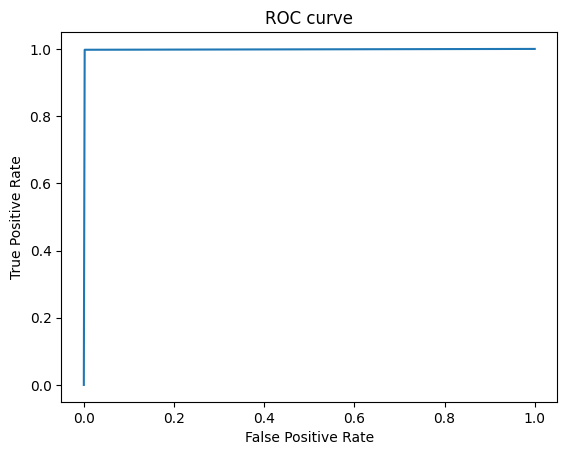

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc = roc_auc_score(binary_labels, binary_predictions)
print("AUC score: ", auc)
fpr, tpr, thresholds = roc_curve(binary_labels, binary_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

We can see that the model preformance with the optimal threshold (from the optuna) gets good ROC accuracy. As mentioned before, the area under the graph is almost 1, so we can clearly say that the model predict very well on unseen data. From the top left graph we can say that the model achieves almost 100% sensitivity score and almost 0% specificity score.


In [ ]:
def get_embedding(model):
    labels = []
    embeddings = []

    ood_test_loader = get_ood_test_loader()
    for inputs, label in ood_test_loader:
      inputs = inputs.to(device)
      label = label.to(device)
      with torch.no_grad():
        embeddings.append(model(inputs).cpu().detach().numpy())
        labels.append(label.cpu().detach().numpy())

    labels = np.array(labels)
    embeddings = np.array(embeddings)

    labels = np.concatenate(labels)
    embeddings = np.concatenate(embeddings)
    return embeddings, labels




**T-SNE visualization**

t-SNE is a powerful technique used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.colors as colors

embeddings, labels = get_embedding(model)
tsne = TSNE(n_components=2)
ood_tsne= tsne.fit_transform(embeddings)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).

<ipython-input-22-ecdd707b8e30>:13: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarra

<ipython-input-24-79acbb65cdab>:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



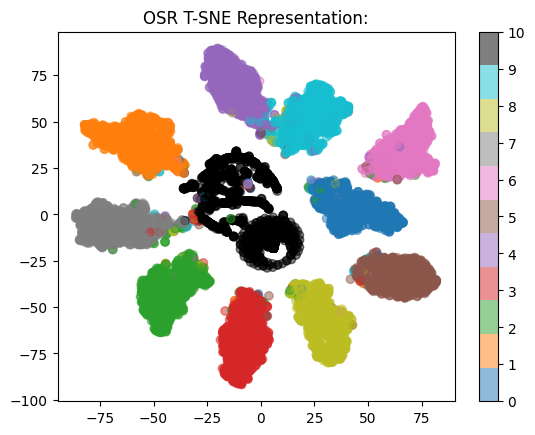

In [ ]:
def Tsne_OOD(embeddings, labels):
  color = plt.cm.get_cmap('tab10', 11)
  color = color(np.linspace(0, 1, 11))
  color[-1] = (0, 0, 0, 1)
  color = colors.ListedColormap(color)
  plt.scatter(ood_tsne[:, 0], ood_tsne[:, 1], c=labels, cmap=color, alpha=0.5)
  cbar = plt.colorbar(ticks=range(11))
  plt.title("OSR T-SNE Representation:")
  plt.show()

Tsne_OOD(embeddings, labels)

As we can see after training the model and applying the hidden layer, the clusters that represent the labels become more separable.
This scatter plot gives us a good idea on what the model is doing to the data "behind the scenes". The learned model changes the space of the features, making each image more distinguishable from one another according to their corresponding label. This action allows the model to choose each image's correct label with the highest probability.


**Evaluation - projects_utils method**

In [ ]:
def eval_model(model, data_loader, device): # copied function from projects_utils and modified
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            output, predicted = model.predict(data)
            mask_mnist = labels < 10
            mask_ood = torch.logical_not(mask_mnist)

            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = predicted[mask_mnist]
            pred_ood = predicted[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()
    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total



acc_mnist, acc_ood, acc_total = eval_model(model, ood_test_loader, device)
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



MNIST Accuracy: 98.64%
OOD Accuracy: 99.95%
Total Accuracy: 98.86%


## Conclusion and Ideas for Improvment ##

We used a model of CNN which involves Monte Carlo Dropuot. It used for uncertainty approximation for recognizing Unknown images (OOD). It calculated by a threshold for the probability of the model output which it is the uncertainty for the output label.
During the inference we used the model with pre-defined number of passes. This helps us to get a better accuracy and give us the abillity to generelize the model, and its behaviour is much like ensemble models (number of passes equals to the number of model, which defined by each dropout).
Our model is efficient because it has the same (maximum) number of weights as our baseline model. The only difference is the dropout which can only remove calculations so it reduces the training time of the model.


We saw that out model generelize and handle OOD dataset (CIFAR) so we are sure that on other datasets our model can behave in the same way.  We saw by the T-SNE that out model could seperate the MNIST point from each other and also from CIFAR datapoint.



Our CNN with dropout model (OSR model) is efficient for several reasons:

1. Regularization: Dropout serves as a regularization technique. It helps prevent overfitting by randomly "dropping out" a portion of neurons during training, forcing the network to rely on a more diverse set of features and preventing the co-adaptation of neurons. This reduces the risk of memorizing noise in the training data, leading to improved generalization to unseen data.

2. Simplicity: Implementing dropout in a CNN is relatively simple and can be easily integrated into the network architecture. It involves only adding dropout layers after convolutional layer (can also be added after fully connected layers), making it a straightforward technique to adopt.

3. Computational Efficiency during Training: Dropout efficiently utilizes computation during training. When a dropout layer is applied, only a fraction of the neurons is active, reducing the computational load. This allows for faster training times, as fewer computations are needed per forward and backward pass through the network.

4. Ensemble Effect: Dropout can be seen as an ensemble technique during training. During each forward pass, different subsets of neurons are active due to dropout, effectively creating multiple sub-networks. The final prediction is an average of predictions made by these sub-networks. This ensemble effect often leads to improved model robustness and better generalization performance.


A continuation of the project can involves several steps to further validates and improves the proposed model's performance on OOD detection:

1. Evaluation on Diverse OOD Datasets: To strengthen the model's generalization capabilities, it is essential to test it on a variety of OOD datasets. Select a diverse set of datasets, representing different domains and characteristics. Evaluate the model's performance on these datasets using metrics such as precision, recall, and F1-score to assess its ability to distinguish between in-distribution and OOD samples accurately.

2. Hyperparameter Tuning: Conduct a systematic search for optimal hyperparameters. Parameters like dropout rate, learning rate, and the number of passes during evaluation can significantly impact the model's performance.

3. Ensemble Methods: Explore the potential benefits of ensemble methods. Consider creating an ensemble of multiple models with different initializations, architectures, or hyperparameters. Combining the predictions from multiple models can often lead to improved performance and better uncertainty estimation.

4. Comparison to State-of-the-art: Benchmark the proposed model against other state-of-the-art OOD detection methods. Compare its performance with existing approaches on different datasets to assess its competitiveness and identify potential areas for improvement. *italicized text*

